<a href="https://colab.research.google.com/github/GergelyTuri/context-project/blob/main/notebooks/pcb_experiments/AT__Video_velocity_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing mouse velocity
* 8/27 setting up
* 9/4 added to `fiberphotometry` repo
* 7/10/24 review by GT, refactored too.
* 7/10/24 GT. The averaged coordinate calculation did not look correct. we would need one set of averaged X coordinate for all parts and one set of averaged coordinates for Y. Switched back to one body part for now. The tracking looks relatively noisy, we need to try to clean it up by getting rig all of those x=0 y=0 points.

In [ ]:
!git clone https://github.com/GergelyTuri/sleep.git
%cd sleep
!pip install .

Cloning into 'sleep'...
remote: Enumerating objects: 1125, done.
remote: Counting objects: 100% (500/500), done.
remote: Compressing objects: 100% (304/304), done.
remote: Total 1125 (delta 312), reused 324 (delta 188), pack-reused 625
Receiving objects: 100% (1125/1125), 33.68 MiB | 24.62 MiB/s, done.
Resolving deltas: 100% (674/674), done.
/content/fiberphotometry/sleep
Processing /content/fiberphotometry/sleep
  Preparing metadata (setup.py) ... done
  Created wheel for sleep: filename=sleep-0.11-py3-none-any.whl size=1011 sha256=5ecd5cbb1f94cc99d98cdcf541967d5f5cc55d308e76b840339ff9a78988c565
  Stored in directory: /tmp/pip-ephem-wheel-cache-zpids8fg/wheels/38/fa/bb/e29c78d0a4d04a73767da40c5e949fced70e8ad00e1474adea
Successfully built sleep
  Attempting uninstall: sleep
    Found existing installation: sleep 0.11
    Uninstalling sleep-0.11:
      Successfully uninstalled sleep-0.11


In [ ]:
%cd /content/sleep/
!pip install .

/content/sleep
Processing /content/sleep
  Preparing metadata (setup.py) ... done
  Created wheel for sleep: filename=sleep-0.11-py3-none-any.whl size=1011 sha256=ae74679a9983409948bd5e384c1754617e81c2c837aed8e7761371d81a9dd2f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-i5l6mglt/wheels/10/eb/42/5281370ac4a2d7b033087761ebaa8f968a9ef5108cbc009a46
Successfully built sleep
  Attempting uninstall: sleep
    Found existing installation: sleep 0.11
    Uninstalling sleep-0.11:
      Successfully uninstalled sleep-0.11


In [ ]:
%cd ..

/content


In [ ]:
!git clone https://github.com/GergelyTuri/fiberphotometry.git

fatal: destination path 'fiberphotometry' already exists and is not an empty directory.


In [ ]:
%cd /content/fiberphotometry/
!pip install .

/content/fiberphotometry
Processing /content/fiberphotometry
  Preparing metadata (setup.py) ... done
  Created wheel for fiber-photometry-analysis: filename=fiber_photometry_analysis-0.1-py3-none-any.whl size=9270 sha256=e4395daad62cf09a775e8069e3290c651c525b7922b4e6cf0a580dc7f6c24da2
  Stored in directory: /tmp/pip-ephem-wheel-cache-gh1fjch8/wheels/4b/b6/cf/916d1f43d06b8bc573d2ec7471e525018bf5ea7bcf83b8e670
Successfully built fiber-photometry-analysis
  Attempting uninstall: fiber-photometry-analysis
    Found existing installation: fiber-photometry-analysis 0.1
    Uninstalling fiber-photometry-analysis-0.1:
      Successfully uninstalled fiber-photometry-analysis-0.1


In [ ]:
!pip install tdt

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go

from sleep.src.classes import core
from fiberphotometry.src import video, behavior_dlc
from scipy.stats import linregress
from scipy.ndimage import gaussian_filter1d

%matplotlib inline

In [ ]:
h5 = '/gdrive/Shareddrives/Turi_lab/DeepLabCut/DLC_model_training/fiberphotometry/serotonin_fiberphotometry/pcb_test-gergo-2024-07-02/videos/drug_experiment-240625-124323_nia_2-240701-094343_Cam1DLC_resnet50_pcb_testJul2shuffle1_1030000.h5'
tdt_path = '/gdrive/Shareddrives/Turi_lab/DeepLabCut/DLC_model_training/fiberphotometry/serotonin_fiberphotometry/pcb_test-gergo-2024-07-02/videos/drug_experiment-240625-124323_nia_2-240701-094343_Cam1DLC_resnet50_pcb_testJul2shuffle1_1030000_labeled.mp4'


In [ ]:
beh_df

scorer    DLC_resnet50_pcb_testJul2shuffle1_1030000                         \
bodyparts                                      nose                          
coords                                            x           y likelihood   
0                                        392.355896  335.531006   0.252568   
1                                        390.801117  355.316040   0.030715   
2                                        392.372711  355.543884   0.004189   
3                                        392.024170  353.537323   0.004789   
4                                        389.555298  352.816223   0.027145   
...                                             ...         ...        ...   
54557                                    181.246689  301.710175   0.968096   
54558                                    181.216492  296.574402   0.979199   
54559                                    183.406509  295.047852   0.987432   
54560                                    186.623627  294.697662   0.987000   
54561                                    189.331406  293.932190   0.998632   

scorer                                                                \
bodyparts    rightear                            leftear               
coords              x           y likelihood           x           y   
0          418.554138  326.892639   0.999837  407.217621  368.079224   
1          412.903412  326.594635   0.999803  416.789703  361.843781   
2          413.539276  326.731567   0.999714  417.014343  361.353882   
3          414.565948  325.805695   0.999757  417.537231  360.927124   
4          414.056000  325.971039   0.999898  417.078949  361.214203   
...               ...         ...        ...         ...         ...   
54557      170.490829  335.892090   0.999985  140.031143  312.580292   
54558      173.011703  333.063110   0.999990  141.053894  308.719177   
54559      174.428955  332.039734   0.999995  141.955383  306.593719   
54560      176.190720  331.158691   0.999996  143.422562  304.414795   
54561      176.836227  330.890289   0.999997  145.583572  304.062592   

scorer                            ...                                     \
bodyparts                  back1  ...                  back2               
coords    likelihood           x  ... likelihood           x           y   
0           0.230847  426.888580  ...   0.999994  461.568665  342.567291   
1           0.999401  429.203857  ...   0.999999  464.647675  338.175964   
2           0.999322  429.637665  ...   0.999999  464.126404  337.789276   
3           0.999855  431.048645  ...   0.999998  465.350342  338.076477   
4           0.999962  431.211761  ...   0.999999  466.180756  337.469299   
...              ...         ...  ...        ...         ...         ...   
54557       0.999903  150.722076  ...   0.999997  149.160538  367.047729   
54558       0.999956  151.400787  ...   0.999997  146.937439  365.017242   
54559       0.999956  152.436859  ...   0.999993  146.906296  363.138031   
54560       0.999967  154.005966  ...   0.999988  146.331268  360.521790   
54561       0.999965  155.115158  ...   0.999993  146.307938  360.293701   

scorer                                                               \
bodyparts                  back3                           tailbase   
coords    likelihood           x           y likelihood           x   
0           0.999871  491.750580  356.179993   0.999976  498.008514   
1           0.999998  494.329712  355.391693   0.999983  507.337402   
2           0.999997  493.768066  354.815643   0.999977  509.573303   
3           0.999998  494.356995  355.337341   0.999989  507.629028   
4           0.999999  495.649536  355.557098   0.999983  507.700836   
...              ...         ...         ...        ...         ...   
54557       0.998671  140.465652  407.171570   0.995489  198.476578   
54558       0.997264  142.356064  405.425751   0.987659  197.897003   
54559       0.995963  143.101318  404.095520   0.968

In [ ]:
beh_df

scorer    DLC_resnet50_pcb_testJul2shuffle1_1030000                         \
bodyparts                                      nose                          
coords                                            x           y likelihood   
0                                        392.355896  335.531006   0.252568   
1                                        390.801117  355.316040   0.030715   
2                                        392.372711  355.543884   0.004189   
3                                        392.024170  353.537323   0.004789   
4                                        389.555298  352.816223   0.027145   
...                                             ...         ...        ...   
54557                                    181.246689  301.710175   0.968096   
54558                                    181.216492  296.574402   0.979199   
54559                                    183.406509  295.047852   0.987432   
54560                                    186.623627  294.697662   0.987000   
54561                                    189.331406  293.932190   0.998632   

scorer                                                                \
bodyparts    rightear                            leftear               
coords              x           y likelihood           x           y   
0          418.554138  326.892639   0.999837  407.217621  368.079224   
1          412.903412  326.594635   0.999803  416.789703  361.843781   
2          413.539276  326.731567   0.999714  417.014343  361.353882   
3          414.565948  325.805695   0.999757  417.537231  360.927124   
4          414.056000  325.971039   0.999898  417.078949  361.214203   
...               ...         ...        ...         ...         ...   
54557      170.490829  335.892090   0.999985  140.031143  312.580292   
54558      173.011703  333.063110   0.999990  141.053894  308.719177   
54559      174.428955  332.039734   0.999995  141.955383  306.593719   
54560      176.190720  331.158691   0.999996  143.422562  304.414795   
54561      176.836227  330.890289   0.999997  145.583572  304.062592   

scorer                            ...                                     \
bodyparts                  back1  ...                  back2               
coords    likelihood           x  ... likelihood           x           y   
0           0.230847  426.888580  ...   0.999994  461.568665  342.567291   
1           0.999401  429.203857  ...   0.999999  464.647675  338.175964   
2           0.999322  429.637665  ...   0.999999  464.126404  337.789276   
3           0.999855  431.048645  ...   0.999998  465.350342  338.076477   
4           0.999962  431.211761  ...   0.999999  466.180756  337.469299   
...              ...         ...  ...        ...         ...         ...   
54557       0.999903  150.722076  ...   0.999997  149.160538  367.047729   
54558       0.999956  151.400787  ...   0.999997  146.937439  365.017242   
54559       0.999956  152.436859  ...   0.999993  146.906296  363.138031   
54560       0.999967  154.005966  ...   0.999988  146.331268  360.521790   
54561       0.999965  155.115158  ...   0.999993  146.307938  360.293701   

scorer                                                               \
bodyparts                  back3                           tailbase   
coords    likelihood           x           y likelihood           x   
0           0.999871  491.750580  356.179993   0.999976  498.008514   
1           0.999998  494.329712  355.391693   0.999983  507.337402   
2           0.999997  493.768066  354.815643   0.999977  509.573303   
3           0.999998  494.356995  355.337341   0.999989  507.629028   
4           0.999999  495.649536  355.557098   0.999983  507.700836   
...              ...         ...         ...        ...         ...   
54557       0.998671  140.465652  407.171570   0.995489  198.476578   
54558       0.997264  142.356064  405.425751   0.987659  197.897003   
54559       0.995963  143.101318  404.095520   0.968

In [ ]:
vid = video.UsbVideo(tdt_path)
fr = vid.video_params['fps']
beh = behavior_dlc.Behavior(h5)
beh_df = beh.data

In [ ]:
x_coords = beh_df[(beh_df.columns.values[0][0],
                 'back1', 'x')]
y_coords = beh_df[(beh_df.columns.values[0][0],
                 'back1', 'y')]

In [ ]:
beh_df

scorer    DLC_resnet50_pcb_testJul2shuffle1_1030000                         \
bodyparts                                      nose                          
coords                                            x           y likelihood   
0                                        174.995728   38.827320   0.434424   
1                                        174.496384   37.724483   0.140806   
2                                        174.524277   37.810322   0.190039   
3                                        174.294937   37.965614   0.190769   
4                                        173.404312   38.736656   0.244429   
...                                             ...         ...        ...   
107998                                   270.865753  362.808929   0.166337   
107999                                   270.847748  362.714325   0.143785   
108000                                   271.643982  363.048004   0.023716   
108001                                   271.772766  363.082520   0.014630   
108002                                   271.695526  362.947296   0.054429   

scorer                                                                \
bodyparts    rightear                            leftear               
coords              x           y likelihood           x           y   
0          133.017288   42.188740   0.999999  148.686661    3.646222   
1          133.357101   41.381199   0.999999  148.146378    3.269478   
2          133.206390   41.184921   0.999999  147.550659    2.955610   
3          132.995865   41.206512   0.999999  147.368607    2.737279   
4          133.274704   41.827168   0.999999  148.115189    5.153017   
...               ...         ...        ...         ...         ...   
107998     305.647278  355.195465   1.000000  297.751831  394.828278   
107999     305.658020  355.163818   1.000000  297.649841  394.811829   
108000     305.968781  355.175262   1.000000  297.223175  394.756378   
108001     305.968567  355.116516   1.000000  297.146515  394.893555   
108002     305.997314  355.120789   1.000000  297.343994  394.814484   

scorer                            ...                                     \
bodyparts                  back1  ...                  back2               
coords    likelihood           x  ... likelihood           x           y   
0           0.999647  120.993065  ...   0.999851  132.929718    2.574856   
1           0.999744  121.398033  ...   0.999783  117.399277    3.051883   
2           0.999601  120.699417  ...   0.999847  117.667534    3.191128   
3           0.999381  120.329498  ...   0.999869  117.620544    3.324071   
4           0.999970  120.841873  ...   0.999783  117.884827    2.975591   
...              ...         ...  ...        ...         ...         ...   
107998      0.999739  316.315735  ...   0.999999  351.255524  369.504211   
107999      0.999745  316.241730  ...   0.999999  351.015350  369.571869   
108000      0.999682  316.807190  ...   0.999999  351.666443  369.636505   
108001      0.999681  316.768311  ...   0.999999  351.575104  369.623779   
108002      0.999619  316.735535  ...   0.999999  351.325806  369.679810   

scorer                                                               \
bodyparts                  back3                           tailbase   
coords    likelihood           x           y likelihood           x   
0           0.001313  126.467300    6.539179   0.001431  147.310593   
1           0.001221  126.720024    6.498923   0.001490  147.272415   
2           0.001132  126.504913    6.547973   0.001253  147.176376   
3           0.001148  126.345993    6.597150   0.001168  138.027908   
4           0.001092  126.709160    6.592833   0.001017  146.894989   
...              ...         ...         ...        ...         ...   
107998      0.999999  387.169312  357.411652   1.000000  408.127380   
107999      0.999999  386.978882  357.551178   1.000000  408.023071   
108000      1.000000  387.165009  357.505981   1.000

In [ ]:
beh_df.keys()[0]

('DLC_resnet50_pcb_testJul2shuffle1_1030000', 'nose', 'x')

In [ ]:

# Extract 'likelihood' values for 'back1'
back1_likelihood = beh_df[('DLC_resnet50_pcb_testJul2shuffle1_1030000', 'back1', 'likelihood')]  # if columns are MultiIndexed
# or
# back1_likelihood = df['back1_likelihood']  # if columns are flat

# Print the extracted values
print(back1_likelihood)


0        0.999994
1        0.999999
2        0.999999
3        0.999998
4        0.999999
           ...   
54557    0.999997
54558    0.999997
54559    0.999993
54560    0.999988
54561    0.999993
Name: (DLC_resnet50_pcb_testJul2shuffle1_1030000, back1, likelihood), Length: 54562, dtype: float64


In [ ]:
# Extract coordinates
x_coords = beh_df[(beh_df.columns.values[0][0], 'back1', 'x')]
y_coords = beh_df[(beh_df.columns.values[0][0], 'back1', 'y')]

# Remove noisy points where both x and y are zero
valid_points = (x_coords > 0) & (y_coords > 0)
likelihood_filter = beh_df[('DLC_resnet50_pcb_testJul2shuffle1_1030000', 'back1', 'likelihood')] > 0.8
x_coords = x_coords[valid_points]
y_coords = y_coords[valid_points]
x_coords = x_coords[likelihood_filter]
y_coords = y_coords[likelihood_filter]

In [ ]:
pdist = beh.pairwise_dist(x_coords)
dist_moved = beh.distance_moved(x_coords,
               y_coords)
dist_moved.sum()

74313.25124287306

18.14708871803233

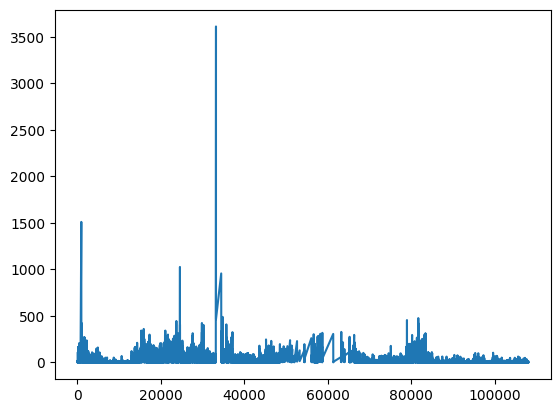

In [ ]:
velo = beh.compute_velocity(x_coords, y_coords, fr)
mean_velo = velo.mean()
velo.plot()
mean_velo

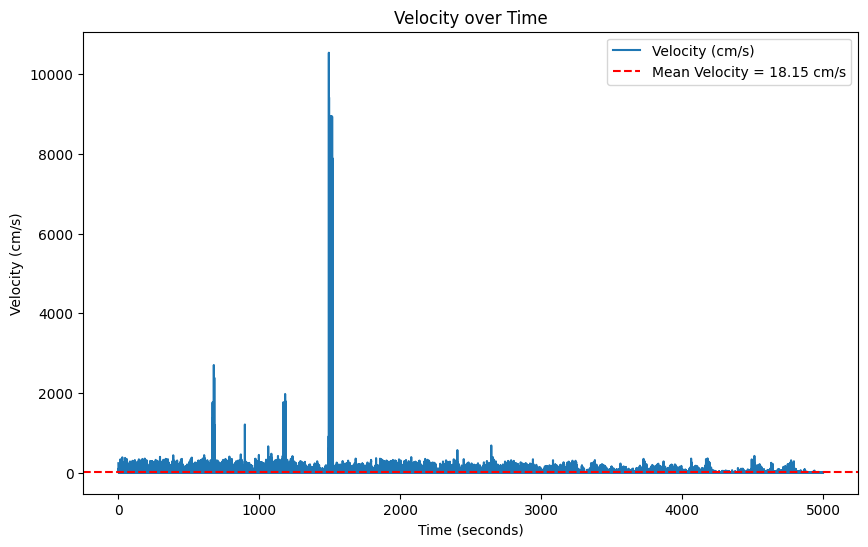

In [103]:
#convert velocity data from framerate to seconds to plot
fr = 20  # Frame rate in Hz (frames per second)

# Compute velocity data

# Compute the time in seconds for each frame
time_in_seconds = np.arange(len(velo)) / fr

# Plotting velocity over time
plt.figure(figsize=(10, 6))
plt.plot(time_in_seconds, velo, label='Velocity (cm/s)')
plt.axhline(y=mean_velo, color='r', linestyle='--', label=f'Mean Velocity = {mean_velo:.2f} cm/s')

# Labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity (cm/s)')
plt.title('Velocity over Time')
plt.legend()
plt.show()

data = pd.DataFrame({
    'Time (seconds)': time_in_seconds,
    'Velocity (cm/s)': velo
})

# Save the DataFrame to a CSV file
csv_file_path = '/gdrive/Shareddrives/Turi_lab/DeepLabCut/DLC_model_training/fiberphotometry/serotonin_fiberphotometry/pcb_test-gergo-2024-07-02/velocity.csv'
data.to_csv(csv_file_path, index=False)

In [ ]:
data = pd.read_csv('/gdrive/Shareddrives/Turi_lab/DeepLabCut/DLC_model_training/fiberphotometry/serotonin_fiberphotometry/serotonin_df.csv')
print(data)

            Time (s)   Z-score
0           8.000962 -2.401990
1           8.001945 -2.398414
2           8.002928 -2.395484
3           8.003912 -2.393185
4           8.004895 -2.391522
...              ...       ...
5076657  4998.557760  4.202528
5076658  4998.558743  4.200373
5076659  4998.559726  4.198319
5076660  4998.560709  4.196394
5076661  4998.561692  4.194661

[5076662 rows x 2 columns]


In [ ]:


#STILL IN WORKS

# Plotting velocity vs. 5HT2A with a regression line
plt.figure(figsize=(10, 6))
plt.scatter(velo, 5HT2A, color='red', s=2, alpha=0.6, label='5HT2A')

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(velo, 5HT2A)
regression_line = slope * velo + intercept

# Plot regression line
plt.plot(velo, regression_line, color='blue', label=f'Regression line (r={r_value:.2f})')

# Labels and title
plt.xlabel('Speed (cm/s)')
plt.ylabel('5HT2A (zscore dF/F)')
plt.title('5HT2A vs Speed with Regression Line')
plt.legend()
plt.show()

# Plotting velocity vs. OXT with a regression line
plt.figure(figsize=(10, 6))
plt.scatter(velo, OXT, color='green', s=2, alpha=0.6, label='OXT')

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(velo, OXT)
regression_line = slope * velo + intercept

# Plot regression line
plt.plot(velo, regression_line, color='blue', label=f'Regression line (r={r_value:.2f})')

# Labels and title
plt.xlabel('Speed (cm/s)')
plt.ylabel('OXT (zscore dF/F)')
plt.title('OXT vs Speed with Regression Line')
plt.legend()
plt.show()


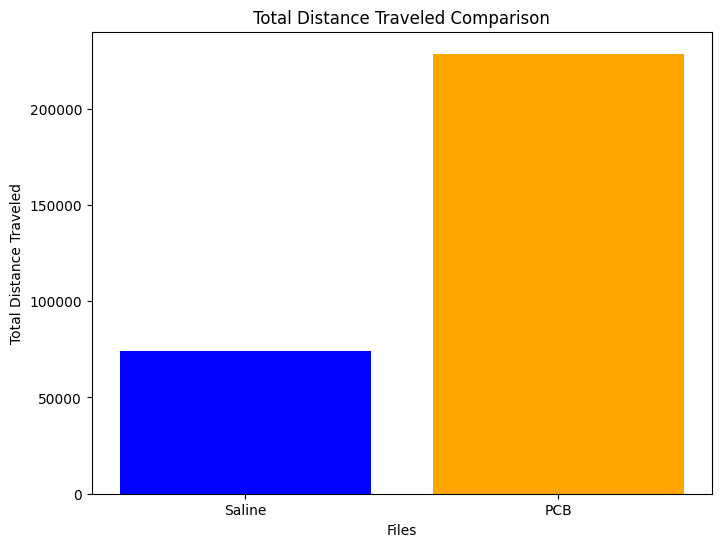

In [ ]:
#plot avg distance traveled
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_and_process_file(file_path):
    beh_df = pd.read_hdf(file_path)

    # Extract coordinates
    x_coords = beh_df[(beh_df.columns.values[0][0], 'back1', 'x')]
    y_coords = beh_df[(beh_df.columns.values[0][0], 'back1', 'y')]

    # Remove noisy points where both x and y are zero
    valid_points = (x_coords > 0) & (y_coords > 0)
    likelihood_filter = beh_df[('DLC_resnet50_pcb_testJul2shuffle1_1030000', 'back1', 'likelihood')] > 0.8
    x_coords = x_coords[valid_points & likelihood_filter]
    y_coords = y_coords[valid_points & likelihood_filter]

    # Compute distance moved
    dist_moved = np.sqrt(np.diff(x_coords)**2 + np.diff(y_coords)**2)
    total_distance = dist_moved.sum()

    return total_distance

# Define file paths for the two HDF5 files
file1_path = '/gdrive/Shareddrives/Turi_lab/DeepLabCut/DLC_model_training/fiberphotometry/serotonin_fiberphotometry/pcb_test-gergo-2024-07-02/videos/drug_experiment-240625-124323_nia_2-240628-133011_Cam1DLC_resnet50_pcb_testJul2shuffle1_1030000.h5'
file2_path = '/gdrive/Shareddrives/Turi_lab/DeepLabCut/DLC_model_training/fiberphotometry/serotonin_fiberphotometry/pcb_test-gergo-2024-07-02/videos/drug_experiment-240625-124323_nia_2-240701-094343_Cam1DLC_resnet50_pcb_testJul2shuffle1_1030000.h5'

# Load and process each file
total_dist1 = load_and_process_file(file1_path)
total_dist2 = load_and_process_file(file2_path)

# Prepare data for plotting
distances = [total_dist1, total_dist2]
labels = ['Saline', 'PCB']

# Plot the bar graph
plt.figure(figsize=(8, 6))
plt.bar(labels, distances, color=['blue', 'orange'])
plt.xlabel('Files')
plt.ylabel('Total Distance Traveled')
plt.title('Total Distance Traveled Comparison')
plt.show()


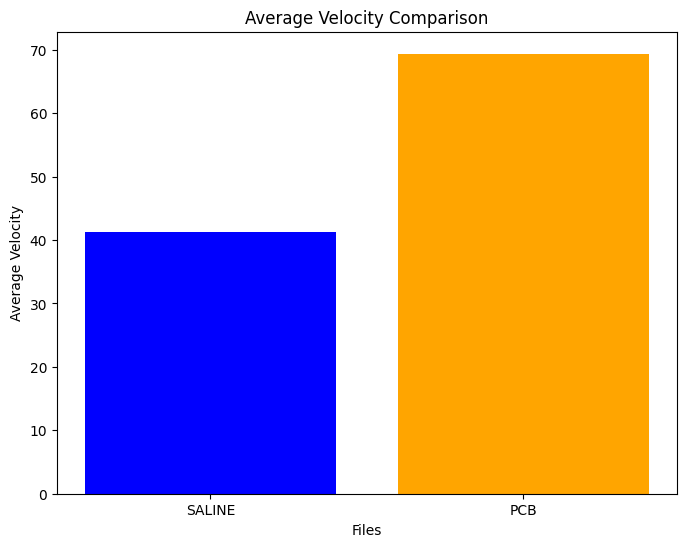

In [ ]:
#plot avg velocitys


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_and_process_file(file_path):
    beh_df = pd.read_hdf(file_path)

    # Extract coordinates
    x_coords = beh_df[(beh_df.columns.values[0][0], 'back1', 'x')]
    y_coords = beh_df[(beh_df.columns.values[0][0], 'back1', 'y')]

    # Remove noisy points where both x and y are zero
    valid_points = (x_coords > 0) & (y_coords > 0)
    likelihood_filter = beh_df[('DLC_resnet50_pcb_testJul2shuffle1_1030000', 'back1', 'likelihood')] > 0.8
    x_coords = x_coords[valid_points & likelihood_filter]
    y_coords = y_coords[valid_points & likelihood_filter]

    # Compute velocity
    dist_moved = np.sqrt(np.diff(x_coords)**2 + np.diff(y_coords)**2)
    velocity = dist_moved / (1 / 30)  # Assuming a frame rate of 30 fps

    # Calculate mean velocity
    mean_velocity = velocity.mean()

    return mean_velocity

# Load and process each file
file1_path = '/gdrive/Shareddrives/Turi_lab/DeepLabCut/DLC_model_training/fiberphotometry/serotonin_fiberphotometry/pcb_test-gergo-2024-07-02/videos/drug_experiment-240625-124323_nia_2-240628-133011_Cam1DLC_resnet50_pcb_testJul2shuffle1_1030000.h5'
file2_path = '/gdrive/Shareddrives/Turi_lab/DeepLabCut/DLC_model_training/fiberphotometry/serotonin_fiberphotometry/pcb_test-gergo-2024-07-02/videos/drug_experiment-240625-124323_nia_2-240701-094343_Cam1DLC_resnet50_pcb_testJul2shuffle1_1030000.h5'

mean_velo1 = load_and_process_file(file1_path)
mean_velo2 = load_and_process_file(file2_path)

# Prepare data for plotting
velocities = [mean_velo1, mean_velo2]
labels = ['SALINE', 'PCB']

# Plot the bar graph
plt.figure(figsize=(8, 6))
plt.bar(labels, velocities, color=['blue', 'orange'])
plt.xlabel('Files')
plt.ylabel('Average Velocity')
plt.title('Average Velocity Comparison')
plt.show()


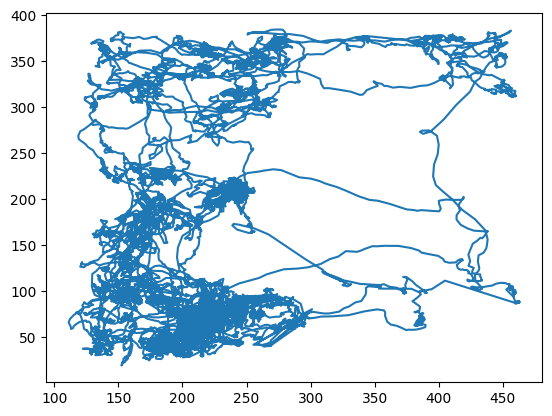

In [ ]:
plt.plot(x_coords, y_coords)

0.006773047871542194

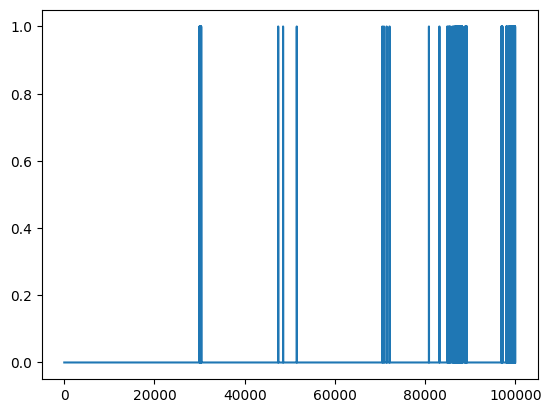

In [ ]:
mob = beh.define_immobility(x_coords, y_coords)
mob.plot()
perc_immob = mob.sum()/len(mob)
perc_immob

In [ ]:
mob_df = pd.DataFrame(mob, columns=['mob'])
mob_df.to_csv('/gdrive/Shareddrives/Turi_lab/DeepLabCut/DLC_model_training/fiberphotometry/serotonin_fiberphotometry/mobility.csv')


In [ ]:
# Plot immobility
fig = go.Figure()

fig.add_trace(go.Scatter(x=mob_df.index, y=mob_df['mob'], mode='lines', name='Immobility'))
fig.update_layout(
    title='Immobility Over Time',
    xaxis_title='Frame',
    yaxis_title='Immobility',
    yaxis=dict(tickmode='array', tickvals=[0, 1], ticktext=['Mobile', 'Immobile'])
)

# Show plot
fig.show()

# Calculate the percentage of immobility
# perc_immob = mob.sum() / len(mob)
# print(f'Percentage of immobility: {perc_immob:.2%}')

In [ ]:
#plot immobility in seconds not framerate

# Assuming 'mob' is already defined
# mob = beh.define_immobility(x_coords, y_coords)
# mob.plot()

# Create DataFrame from immobility data
mob_df = pd.DataFrame(mob, columns=['mob'])

# Convert frame numbers to time in seconds
frame_rate = 20
mob_df['Time (s)'] = mob_df.index / frame_rate

# Save DataFrame to CSV (optional)
mob_df.to_csv('/gdrive/Shareddrives/Turi_lab/DeepLabCut/DLC_model_training/fiberphotometry/serotonin_fiberphotometry/mobility.csv', index=False)

# Plot immobility with time in seconds
fig = go.Figure()

fig.add_trace(go.Scatter(x=mob_df['Time (s)'], y=mob_df['mob'], mode='lines', name='Immobility'))
fig.update_layout(
    title='Immobility Over Time',
    xaxis_title='Time (s)',
    yaxis_title='Immobility',
    yaxis=dict(tickmode='array', tickvals=[0, 1], ticktext=['Mobile', 'Immobile'])
)

# Show plot
fig.show()



ValueError: x and y must have same first dimension, but have shapes (74390,) and (73502,)

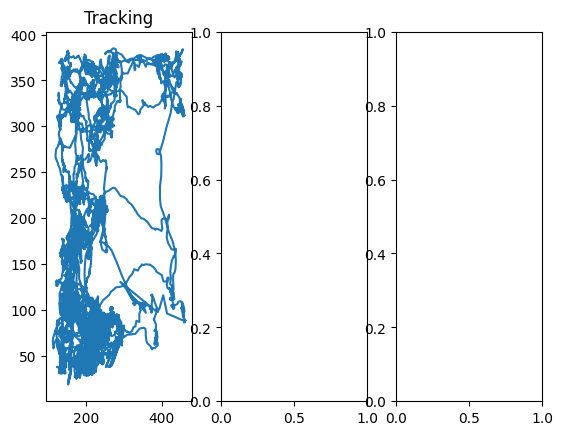

In [ ]:
fig, axs = plt.subplots(ncols=3)
axs[0].plot(x_coords, y_coords)
axs[0].set_title('Tracking')
dist = beh.distance_moved(x_coords, y_coords)
x = np.linspace(0, len(beh_df.index), num=len(beh_df.index))
velo = beh.compute_velocity(x_coords, y_coords, fr)
axs[1].plot(x, velo)
axs[1].axhline(velo.mean(), color='k', label='ok')
axs[1].set_title('Speed')
# axs[1].set_ylim((-0.1, 10))

mob_immob = beh.define_immobility(x_coords, y_coords)
axs[2].plot(x, mob_immob)
axs[2].set_title('Mobility - immobility')
axs[2].set_ylim((-0.1, 1.2))

# # Save the figure
# fig.savefig('tracking_analysis.png', dpi=300, bbox_inches='tight')
